In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import ccdproc as ccdp
from ccdproc import trim_image
from ccdproc import subtract_overscan

import os

import pickle as pickle

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from astropy.io import fits
from astropy import units as u
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats
from astropy.modeling.models import Gaussian2D

from astropy.visualization import make_lupton_rgb, SqrtStretch, ZScaleInterval

import scipy.ndimage.interpolation as interp

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
raw_dir='/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/'
overscan_dir='/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/overscan_sub/'
reduced_dir='/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/'

### Perform overscan subtraction (i.e., bias subtraction)

First, let's define a function to perform overscan subtraction and trimming of all images.

In [3]:
def overscan_subtraction(infiles, outdir):
    if(not outdir.endswith('/')): outdir=outdir+'/'
    if(not os.path.exists(outdir)): os.mkdir(outdir)
    
    #Scan inbox directory for .fit files
    for image in infiles:
        outfile=outdir+os.path.split(image)[1]  #Define output file
        print('Processing image '+image)
           
        #Generate a CCDData object from the image's data array
        hdul = fits.open(image)
        ccddata = CCDData(hdul[0].data, unit=u.adu)

        #subtract overscan row-by-row and crop region
        overscan_subtracted_data = subtract_overscan(ccddata, overscan=ccddata[:, 0:50]) #Only using left overscan
        overscan_subtracted_trimmed_data = np.asarray(trim_image(overscan_subtracted_data[:, 50:2098]))
            
        #Update header information for image width
        header = hdul[0].header
        header['NAXIS1'] = 2048
        header['IMAGEW'] = 2048
    
        #Save data to outbox directory.
        hdul[0].data = overscan_subtracted_trimmed_data
        hdul.writeto(outfile,overwrite=True)

We need to define our input files, and our output directory.  

In [4]:
#Create the list of input files
indir=raw_dir  
filelist=[]
for file in os.listdir(indir):
    if(file.endswith("b.fit") or file.endswith("d.fit") or file.endswith("r.fit") or
       file.endswith("v.fit") or file.endswith("i.fit")): #Find all image and dark files
           filelist.append(os.path.join(indir, file))

#Define the output directory  
outdir=overscan_dir  
print('output directory:', outdir)
#print(filelist)  #Run this command to check your list of files

output directory: /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/overscan_sub/


In [5]:
#Run overscan subtraction on filelist
overscan_subtraction(filelist, outdir)

Processing image /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/24P15-066v.fit
Processing image /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/24P15-031v.fit
Processing image /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/24P15-027v.fit
Processing image /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/24P15-070v.fit
Processing image /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/24P15-006r.fit
Processing image /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/24P15-007v.fit
Processing image /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/24P15-050v.fit
Processing image /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/24P15-046v.fit
Processing image /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/raw/24P15-011v.fit
Processing image /Users/mari

Do a visual inspection to make sure the routine worked as expected, and that your overscan-subtrated image has the correct size (2048 x 2048).

*You will need to replace the presub and postsub file names with your file names!*

Shapes of images:  (2048, 2148) (2048, 2048)
Mean values in images: 5799.7437823702285 3669.9301452064487


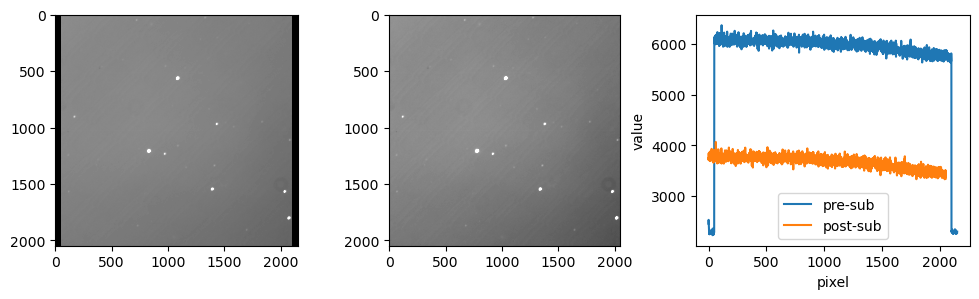

In [6]:
presub_file=raw_dir+'24P15-027v.fit' #Replace!!
postsub_file=overscan_dir+'24P15-027v.fit' #Replace!!
presub_hdul = fits.open(presub_file)   #Read in pre-subtraction image
postsub_hdul = fits.open(postsub_file) #Read in post-subtraction image
presub_img = presub_hdul[0].data
postsub_img = postsub_hdul[0].data

fig=plt.figure(figsize=(12,3))

#Plot pre-sub image
ax1=fig.add_subplot(131)
ax1.imshow(presub_img, cmap='gray',vmin=np.median(presub_img)*0.7, vmax=np.median(presub_img)*1.3)

#Plot post-sub image
ax2=fig.add_subplot(132)
ax2.imshow(postsub_img, cmap='gray',vmin=np.median(postsub_img)*0.7, vmax=np.median(postsub_img)*1.3)

#Plot one row of each image, to compare
ax3=fig.add_subplot(133)
ax3.plot(presub_img[1250,:],label='pre-sub')
ax3.plot(postsub_img[1250,:],label='post-sub')
ax3.legend()
ax3.set_xlabel('pixel')
ax3.set_ylabel('value')

print('Shapes of images: ',np.shape(presub_img),np.shape(postsub_img))
print('Mean values in images:', np.mean(presub_img),np.mean(postsub_img))

### Create a master dark

First inspect exposure times to decide on strategy.

Option 1: Average all dark frames with same exposure time as science frames.

Option 2: Subtract bias from all dark frames, then scale by exposure time for each science frame.

In [7]:
#Inspect all images to look at exposure times of science and dark frames
dark_ifc = ccdp.ImageFileCollection(overscan_dir,glob_include='*d.fit')  #Find all darks
dark_ifc.summary['file','imagetyp','exptime'].show_in_notebook()

#Dark frames have a range of exposure times, and only some match our flats.
#I'm going to make an average of the 30s darks, and then scale those later to 
#match the science exposure times

idx,file,imagetyp,exptime
0,24P15-001d.fit,Dark Frame,60.0
1,24P15-002d.fit,Dark Frame,60.0
2,24P15-003d.fit,Dark Frame,60.0
3,24P15-004d.fit,Dark Frame,60.0
4,24P15-005d.fit,Dark Frame,60.0
5,24P15-006d.fit,Dark Frame,60.0
6,24P15-007d.fit,Dark Frame,60.0
7,24P15-008d.fit,Dark Frame,60.0
8,24P15-009d.fit,Dark Frame,60.0
9,24P15-010d.fit,Dark Frame,60.0


Combine darks into a master dark

In [8]:
#ID all dark files with 60s exposures
dark_ifc=ccdp.ImageFileCollection(overscan_dir,glob_include='*d.fit')
dark_files = dark_ifc.files_filtered(exptime=60.0)  #extract all darks with 60s exposures

#Read in all of these darks
dark_list=[]
for mydark in dark_files:
    print("Reading",mydark)
    dark_ccd=CCDData.read(overscan_dir+mydark, unit="adu")     
    dark_list.append(dark_ccd)

#Combine all darks and write to file
combined_dark = ccdp.combine(dark_list, unit='adu', method='average',
                             output_file=overscan_dir+'master_dark_60s.fit',overwrite_output=True)

Reading 24P15-001d.fit
Reading 24P15-002d.fit
Reading 24P15-003d.fit
Reading 24P15-004d.fit
Reading 24P15-005d.fit
Reading 24P15-006d.fit
Reading 24P15-007d.fit
Reading 24P15-008d.fit
Reading 24P15-009d.fit
Reading 24P15-010d.fit
Reading 24P15-011d.fit


Inspect images to make sure they make some sense. The master dark should have lower noise

Text(0, 0.5, 'value')

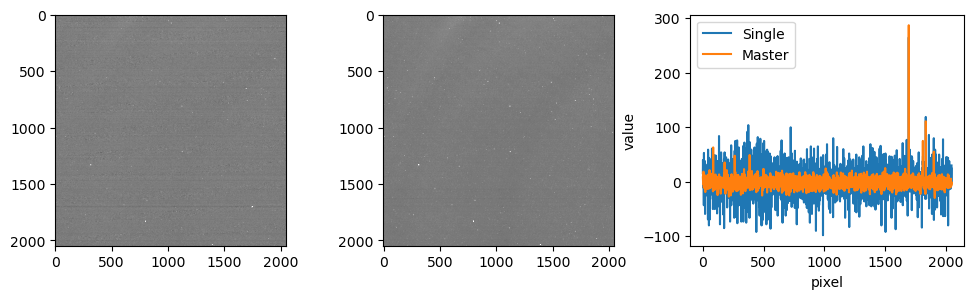

In [9]:
master_dark_file=overscan_dir+'master_dark_60s.fit' #Read in master dark image
master_dark_hdul = fits.open(master_dark_file)   
master_dark_img = master_dark_hdul[0].data

dark_file=overscan_dir+'24P15-001d.fit'  #Read in single dark image
dark_hdul = fits.open(dark_file)
dark_img = dark_hdul[0].data

fig=plt.figure(figsize=(12,3))
#Plot bias image
ax1=fig.add_subplot(131)
ax1.imshow(dark_img, cmap='gray',vmin=-80, vmax=80)
ax2=fig.add_subplot(132)
ax2.imshow(master_dark_img, cmap='gray',vmin=-50, vmax=50)

#Plot one row of each image, to compare
ax3=fig.add_subplot(133)
ax3.plot(dark_img[1250,:],label='Single')
ax3.plot(master_dark_img[1250,:],label='Master')
ax3.legend()
ax3.set_xlabel('pixel')
ax3.set_ylabel('value')

### Process V flats

Reduce V flat files

In [10]:
#First, select all V-filter flats (Use the log to select!)
science_ifc=ccdp.ImageFileCollection(overscan_dir,filenames=['24P15-001v.fit','24P15-002v.fit','24P15-003v.fit',
                                                             '24P15-004v.fit','24P15-005v.fit','24P15-006v.fit',
                                                             '24P15-007v.fit','24P15-008v.fit','24P15-009v.fit',
                                                             '24P15-010v.fit','24P15-011v.fit'])
science_files = science_ifc.files_filtered()

#Read master dark
master_dark_file=overscan_dir+'master_dark_60s.fit' 
master_dark_ccd=CCDData.read(master_dark_file, unit="adu")

#Process flats
for i, myfile in enumerate(science_files):
    print("Processing ", myfile)
    science_ccd = CCDData.read(overscan_dir+myfile, unit="adu") 
 
    #Subtract the dark from the flat image
    reduced_ccd = ccdp.subtract_dark(science_ccd, master_dark_ccd,
                                      exposure_time='EXPTIME', #Name of exposure time in header
                                      exposure_unit=u.second, scale=True)
    #Make sure to set scale=True since the data and darks have different exposure times
    
    #Divide each image by median so they're on the same scale
    factor=1./np.median(reduced_ccd.data) #Compute median
    reduced_ccd=reduced_ccd.multiply(factor * u.adu)
    
    #Write file out
    outfile=reduced_dir+myfile
    print("Writing reduced image data to:",outfile)
    reduced_ccd.write(outfile,overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Processing  24P15-001v.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-001v.fit
Processing  24P15-002v.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-002v.fit
Processing  24P15-003v.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-003v.fit
Processing  24P15-004v.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-004v.fit
Processing  24P15-005v.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-005v.fit
Processing  24P15-006v.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/final_

Combine V flats

In [11]:
#Define the list of *reduced* V flats (same names as above, but now the reduced directory)
#I'm not usinv 13v.fit because it overlaps too closely with another image
#I'm also using an odd number, so the median will (hopefully) not include any stars
Vflat_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24P15-001v.fit','24P15-002v.fit','24P15-003v.fit',
                                                          '24P15-004v.fit','24P15-005v.fit','24P15-006v.fit',
                                                          '24P15-007v.fit','24P15-008v.fit','24P15-009v.fit',
                                                          '24P15-010v.fit','24P15-011v.fit'])
Vflat_files = Vflat_ifc.files_filtered(include_path=True)
print("To be combined:")
print(Vflat_files)

combined_Vflat = ccdp.combine(Vflat_files,method='median')
combined_Vflat.write(reduced_dir+'vFLAT.fit',overwrite=True)

To be combined:
['/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-001v.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-002v.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-003v.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-004v.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-005v.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-006v.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-007v.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-008v.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-009v.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/final_project/data/reduced/24P15-010v.fit', '/U

Inspect

Text(0, 0.5, 'value')

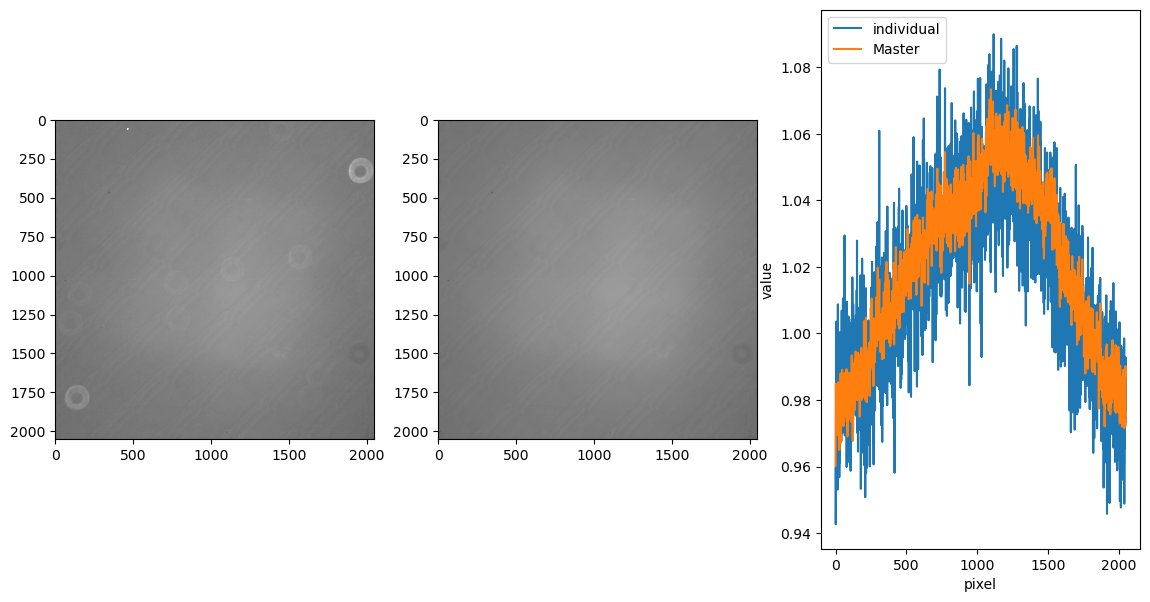

In [12]:
master_flat_file=reduced_dir+'vFLAT.fit' #Read in master flat image
master_flat_hdul = fits.open(master_flat_file)   
master_flat_img = master_flat_hdul[0].data

flat_file=overscan_dir+'24P15-010v.fit' #Read in single flat image
flat_hdul = fits.open(flat_file)
flat_img = flat_hdul[0].data

fig=plt.figure(figsize=(14,7))
#Plot flat image
ax1=fig.add_subplot(131)
ax1.imshow(flat_img, cmap='gray',vmin=np.median(flat_img)*0.7, vmax=np.median(flat_img)*1.3)
ax2=fig.add_subplot(132)
ax2.imshow(master_flat_img, cmap='gray',vmin=np.median(master_flat_img)*0.7, vmax=np.median(master_flat_img)*1.3)

#Plot one row 
ax3=fig.add_subplot(133)
ax3.plot(flat_img[1250,:]/np.median(flat_img),label='individual')
ax3.plot(master_flat_img[1250,:],label='Master')
ax3.legend()
ax3.set_xlabel('pixel')
ax3.set_ylabel('value')

### Process B flats

Reduce B flat files

In [13]:
#First, select all V-filter flats (Use the log to select!)
science_ifc=ccdp.ImageFileCollection(overscan_dir,filenames=['24M25-007b.fit','24M25-008b.fit',
                                                             '24M25-009b.fit','24M25-010b.fit'])
science_files = science_ifc.files_filtered()

#Read master dark
master_dark_file=overscan_dir+'master_dark_60s.fit' 
master_dark_ccd=CCDData.read(master_dark_file, unit="adu")

#Process flats
for i, myfile in enumerate(science_files):
    print("Processing ", myfile)
    science_ccd = CCDData.read(overscan_dir+myfile, unit="adu") 
 
    #Subtract the dark from the flat image
    reduced_ccd = ccdp.subtract_dark(science_ccd, master_dark_ccd,
                                      exposure_time='EXPTIME', #Name of exposure time in header
                                      exposure_unit=u.second, scale=True)
    #Make sure to set scale=True since the data and darks have different exposure times
    
    #Divide each image by median so they're on the same scale
    factor=1./np.median(reduced_ccd.data) #Compute median
    reduced_ccd=reduced_ccd.multiply(factor * u.adu)
    
    #Write file out
    outfile=reduced_dir+myfile
    print("Writing reduced image data to:",outfile)
    reduced_ccd.write(outfile,overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Processing  24M25-007b.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-007b.fit
Processing  24M25-008b.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-008b.fit
Processing  24M25-009b.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-009b.fit
Processing  24M25-010b.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-010b.fit


Combine B flats

In [14]:
#Define the list of *reduced* V flats (same names as above, but now the reduced directory)
#I'm not usinv 13v.fit because it overlaps too closely with another image
#I'm also using an odd number, so the median will (hopefully) not include any stars
Vflat_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24M25-007b.fit','24M25-008b.fit','24M25-010b.fit'])
Vflat_files = Vflat_ifc.files_filtered(include_path=True)
print("To be combined:")
print(Vflat_files)

combined_Vflat = ccdp.combine(Vflat_files,method='median')
combined_Vflat.write(reduced_dir+'bFLAT.fit',overwrite=True)

To be combined:
['/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-007b.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-008b.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-010b.fit']


Inspect B flats

Text(0, 0.5, 'value')

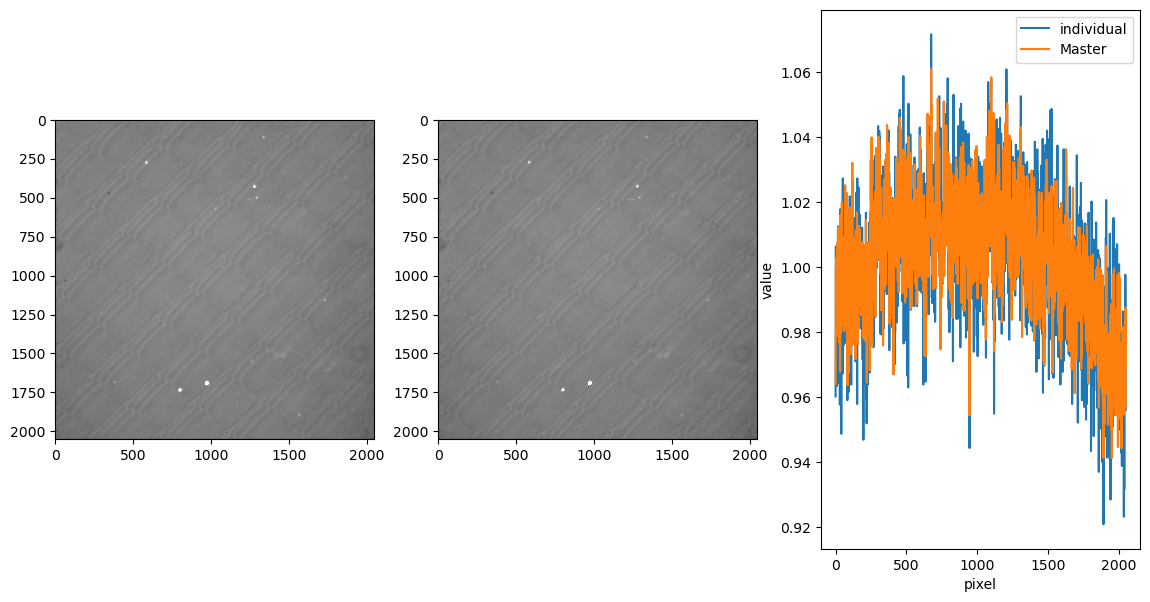

In [15]:
master_flat_file=reduced_dir+'bFLAT.fit' #Read in master flat image
master_flat_hdul = fits.open(master_flat_file)   
master_flat_img = master_flat_hdul[0].data

flat_file=overscan_dir+'24M25-007b.fit'  #Read in single flat image
flat_hdul = fits.open(flat_file)
flat_img = flat_hdul[0].data

fig=plt.figure(figsize=(14,7))
#Plot flat image
ax1=fig.add_subplot(131)
ax1.imshow(flat_img, cmap='gray',vmin=np.median(flat_img)*0.7, vmax=np.median(flat_img)*1.3)
ax2=fig.add_subplot(132)
ax2.imshow(master_flat_img, cmap='gray',vmin=np.median(master_flat_img)*0.7, vmax=np.median(master_flat_img)*1.3)

#Plot one row 
ax3=fig.add_subplot(133)
ax3.plot(flat_img[1250,:]/np.median(flat_img),label='individual')
ax3.plot(master_flat_img[1250,:],label='Master')
ax3.legend()
ax3.set_xlabel('pixel')
ax3.set_ylabel('value')

### Process R flats

Reduce R flat files

In [16]:
#First, select all V-filter flats (Use the log to select!)
science_ifc=ccdp.ImageFileCollection(overscan_dir,filenames=['24M25-015r.fit','24M25-016r.fit',
                                                            '24M25-017r.fit'])
science_files = science_ifc.files_filtered()

#Read master dark
master_dark_file=overscan_dir+'master_dark_60s.fit' 
master_dark_ccd=CCDData.read(master_dark_file, unit="adu")

#Process flats
for i, myfile in enumerate(science_files):
    print("Processing ", myfile)
    science_ccd = CCDData.read(overscan_dir+myfile, unit="adu") 
 
    #Subtract the dark from the flat image
    reduced_ccd = ccdp.subtract_dark(science_ccd, master_dark_ccd,
                                      exposure_time='EXPTIME', #Name of exposure time in header
                                      exposure_unit=u.second, scale=True)
    #Make sure to set scale=True since the data and darks have different exposure times
    
    #Divide each image by median so they're on the same scale
    factor=1./np.median(reduced_ccd.data) #Compute median
    reduced_ccd=reduced_ccd.multiply(factor * u.adu)
    
    #Write file out
    outfile=reduced_dir+myfile
    print("Writing reduced image data to:",outfile)
    reduced_ccd.write(outfile,overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Processing  24M25-015r.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-015r.fit
Processing  24M25-016r.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-016r.fit
Processing  24M25-017r.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-017r.fit


Combine R flats

In [17]:
#Define the list of *reduced* V flats (same names as above, but now the reduced directory)
#I'm not usinv 13v.fit because it overlaps too closely with another image
#I'm also using an odd number, so the median will (hopefully) not include any stars
Vflat_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24M25-015r.fit','24M25-016r.fit',
                                                          '24M25-017r.fit'])
Vflat_files = Vflat_ifc.files_filtered(include_path=True)
print("To be combined:")
print(Vflat_files)

combined_Vflat = ccdp.combine(Vflat_files,method='median')
combined_Vflat.write(reduced_dir+'rFLAT.fit',overwrite=True)

To be combined:
['/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-015r.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-016r.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-017r.fit']


Inspect R flats

Text(0, 0.5, 'value')

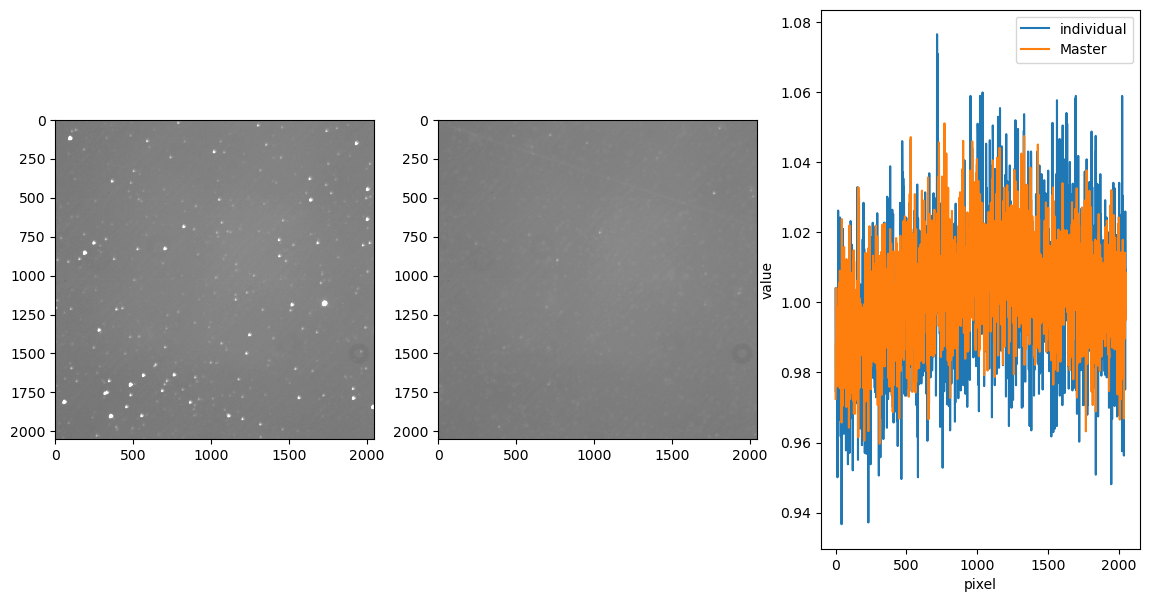

In [18]:
master_flat_file=reduced_dir+'rFLAT.fit' #Read in master flat image
master_flat_hdul = fits.open(master_flat_file)   
master_flat_img = master_flat_hdul[0].data

flat_file=overscan_dir+'24M25-015r.fit'  #Read in single flat image
flat_hdul = fits.open(flat_file)
flat_img = flat_hdul[0].data

fig=plt.figure(figsize=(14,7))
#Plot flat image
ax1=fig.add_subplot(131)
ax1.imshow(flat_img, cmap='gray',vmin=np.median(flat_img)*0.7, vmax=np.median(flat_img)*1.3)
ax2=fig.add_subplot(132)
ax2.imshow(master_flat_img, cmap='gray',vmin=np.median(master_flat_img)*0.7, vmax=np.median(master_flat_img)*1.3)

#Plot one row 
ax3=fig.add_subplot(133)
ax3.plot(flat_img[1250,:]/np.median(flat_img),label='individual')
ax3.plot(master_flat_img[1250,:],label='Master')
ax3.legend()
ax3.set_xlabel('pixel')
ax3.set_ylabel('value')

### Process I flats

Reduce I flat files

In [19]:
#First, select all V-filter flats (Use the log to select!)
science_ifc=ccdp.ImageFileCollection(overscan_dir,filenames=['24M25-003i.fit','24M25-004i.fit',
                                                             '24M25-005i.fit','24M25-006i.fit'])
science_files = science_ifc.files_filtered()

#Read master dark
master_dark_file=overscan_dir+'master_dark_60s.fit' 
master_dark_ccd=CCDData.read(master_dark_file, unit="adu")

#Process flats
for i, myfile in enumerate(science_files):
    print("Processing ", myfile)
    science_ccd = CCDData.read(overscan_dir+myfile, unit="adu") 
 
    #Subtract the dark from the flat image
    reduced_ccd = ccdp.subtract_dark(science_ccd, master_dark_ccd,
                                      exposure_time='EXPTIME', #Name of exposure time in header
                                      exposure_unit=u.second, scale=True)
    #Make sure to set scale=True since the data and darks have different exposure times
    
    #Divide each image by median so they're on the same scale
    factor=1./np.median(reduced_ccd.data) #Compute median
    reduced_ccd=reduced_ccd.multiply(factor * u.adu)
    
    #Write file out
    outfile=reduced_dir+myfile
    print("Writing reduced image data to:",outfile)
    reduced_ccd.write(outfile,overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Processing  24M25-003i.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-003i.fit
Processing  24M25-004i.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-004i.fit
Processing  24M25-005i.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-005i.fit
Processing  24M25-006i.fit
Writing reduced image data to: /Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-006i.fit


Combine I flats

In [20]:
#Define the list of *reduced* V flats (same names as above, but now the reduced directory)
#I'm not usinv 13v.fit because it overlaps too closely with another image
#I'm also using an odd number, so the median will (hopefully) not include any stars
Vflat_ifc=ccdp.ImageFileCollection(reduced_dir,filenames=['24M25-003i.fit','24M25-004i.fit','24M25-006i.fit'])
Vflat_files = Vflat_ifc.files_filtered(include_path=True)
print("To be combined:")
print(Vflat_files)

combined_Vflat = ccdp.combine(Vflat_files,method='median')
combined_Vflat.write(reduced_dir+'iFLAT.fit',overwrite=True)

To be combined:
['/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-003i.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-004i.fit', '/Users/mariahjones/Desktop/Research/projects/ASTR240/MCI/reduced/24M25-006i.fit']


Inspect I flats

Text(0, 0.5, 'value')

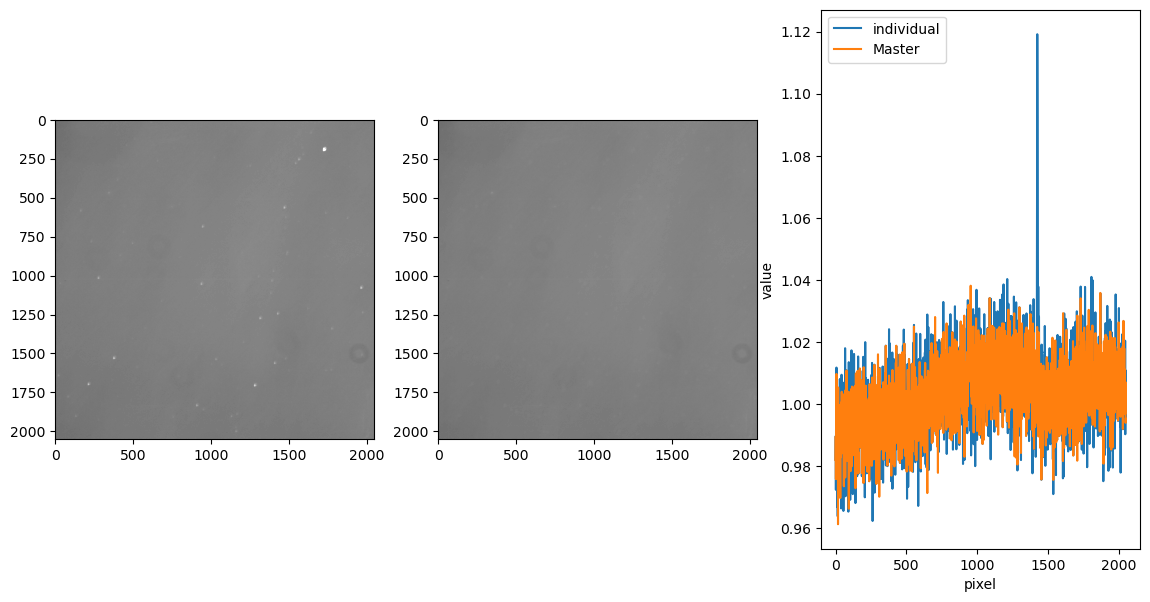

In [21]:
master_flat_file=reduced_dir+'iFLAT.fit' #Read in master flat image
master_flat_hdul = fits.open(master_flat_file)   
master_flat_img = master_flat_hdul[0].data

flat_file=overscan_dir+'24M25-003i.fit'  #Read in single flat image
flat_hdul = fits.open(flat_file)
flat_img = flat_hdul[0].data

fig=plt.figure(figsize=(14,7))
#Plot flat image
ax1=fig.add_subplot(131)
ax1.imshow(flat_img, cmap='gray',vmin=np.median(flat_img)*0.7, vmax=np.median(flat_img)*1.3)
ax2=fig.add_subplot(132)
ax2.imshow(master_flat_img, cmap='gray',vmin=np.median(master_flat_img)*0.7, vmax=np.median(master_flat_img)*1.3)

#Plot one row 
ax3=fig.add_subplot(133)
ax3.plot(flat_img[1250,:]/np.median(flat_img),label='individual')
ax3.plot(master_flat_img[1250,:],label='Master')
ax3.legend()
ax3.set_xlabel('pixel')
ax3.set_ylabel('value')